In [ ]:
# условие https://www.notion.so/25a72f2aedc24b01828b28d8bdbac03f

# 1) Есть флоу обработки заявки
# Пояснения:
# Звонок оператора делается с целью довести потенциального студента до вводного урока
# Вводный урок проводится с целью продемонстрировать работу платформы и показать, какие мы крутые → как следствие человек с большей вероятностью купит (гипотеза)
# 2) Есть конверсия, которую мы хотим оптимизировать
# С1 =(количество заявок, на которые поступила первая оплата) / (количество поступивших заявок)
# Чем она больше, тем лучше.
# 3) Есть данные

#  0   order_id - id заявки
#  1   source - откуда поступила заявка
#  2   application_datetime - когда поступила заявка
#  3   gender - пол
#  4   first_call - время первого звонка оператора
#  5   first_reach - время звонка оператора, на который ответили
#  6   operator_group_type - тип группы оператора 1 линии
#  7   operator_group_name - название группы оператора 1 линии
#  8   trial_appointment_datetime -  время проведенеия вводного урока
#  9   appointment_added_by_id - id оператора, который назначил вводный урок
# 10   is_paid - поступила первая оплата = 1, не поступила = 0
# 4) Изучи, пожалуйста, данные и дай нам рекомендации в самом низу файла. Рекомендации должны быть максимально четкие, представь, что ты пишешь их для менеджера.
# На что обратить внимание? 
# Что сделать? 
# Исходи из того, что мы хотим растить C1.
# 5) Если решение будет на python в ipynb - плюсик в карму.
# 6) Рассуждения на пути к решению для нас тоже важны.

In [2]:
import pandas as pd
from scipy.stats import stats as st
from matplotlib import pyplot as plt
import numpy as np

df_orders = pd.read_csv('applicant_task.csv')

# определяем C1
C1 = df_orders['is_paid'].mean()*100
print(f'Общая конверсия в первую покупку составляет {C1}%')
df_orders.describe()


Общая конверсия в первую покупку составляет 50.18%


,order_id,gender,appointment_added_by_id,is_paid
count,1.000000e+04,5084.000000,1.000000e+04,10000.000000
mean,1.076241e+07,0.593627,5.180934e+06,0.501800
std,1.270724e+06,0.491204,2.850973e+06,0.500022
min,3.896499e+06,0.000000,-2.000000e+00,0.000000
25%,1.034630e+07,0.000000,3.969171e+06,0.000000
50%,1.103726e+07,1.000000,5.550269e+06,1.000000
75%,1.145767e+07,1.000000,6.453798e+06,1.000000
max,1.196107e+07,1.000000,1.129586e+07,1.000000


In [3]:
# приводит даты к формату datetime
df_orders['application_datetime'] = pd.to_datetime(df_orders['application_datetime'])
df_orders['first_call'] = pd.to_datetime(df_orders['first_call'])
df_orders['first_reach'] = pd.to_datetime(df_orders['first_reach'])
df_orders['trial_appointment_datetime'] = pd.to_datetime(df_orders['trial_appointment_datetime'])

In [4]:
# функция, которая группирует данные датафрейма (df) по интересующему критерию (measure), рассчитывает C1 и возвращает
# датафрейм с колонками ['критерий', 'кол-во заявок', 'кол-во оплат', 'конверсия C1']
def calculation_с1(df, measure):
    cnt_orders = df['order_id'].groupby(df[measure]).count().sort_values(ascending = False).reset_index()
    cnt_paid = df['order_id'].loc[df['is_paid'] == 1].groupby(df[measure]).count().sort_values(ascending = False).reset_index()
    df_measure = pd.merge(cnt_orders, cnt_paid, on=measure)
    df_measure.columns=[measure, 'cnt_orders', 'cnt_is_paid']
    df_measure[f'c1_{measure}'] = round(df_measure['cnt_is_paid']/df_measure['cnt_orders']*100, 2)
    return df_measure.sort_values(f'c1_{measure}', ascending = False)

def calculation_с1_month(df, measure):
    cnt_orders = df.groupby(df_orders[measure].dt.month).count().reset_index()
    cnt_paid = df.loc[df_orders['is_paid'] == 1].groupby(df_orders[measure].dt.month).count().reset_index()
    df_measure = pd.merge(cnt_orders, cnt_paid, on=measure)
    df_measure.columns=['month', 'cnt_orders', 'cnt_is_paid']
    df_measure['c1_month'] = round(df_measure['cnt_is_paid']/df_measure['cnt_orders']*100, 2)
    return df_measure

In [5]:
# определяем С1 в зависимости от пола (предположим, что 0 - это мужчина, 1 - женщина)
C1_men = round(df_orders['order_id'].loc[df_orders['is_paid'] == 1].loc[df_orders['gender'] == 0.0].count()/df_orders['order_id'].loc[df_orders['gender'] == 0.0].count()*100, 2)
C1_women = round(df_orders['order_id'].loc[df_orders['is_paid'] == 1].loc[df_orders['gender'] == 1.0].count()/df_orders['order_id'].loc[df_orders['gender'] == 1.0].count()*100, 2)
C1_gender_nan = round(df_orders['order_id'].loc[df_orders['is_paid'] == 1].loc[df_orders['gender'].isnull()].count()/df_orders['order_id'].loc[df_orders['gender'].isnull()].count()*100, 2)
print(f'Конверсия в первую покупку для мужчин составляет {C1_men}%')
print(f'Конверсия в первую покупку для женщин составляет {C1_women}%')
print(f'Конверсия в первую покупку для юзеров без указания пола составляет {C1_gender_nan}%')
# делаем вывод, что С1 по полу незначительно отличается, однако конверсия у пола 1 (предположительно женщины) выше.
# Стоит попробовать сделать рекламную акцию, нацеленную больше на женскую аудитрию, чтобы дополнительно проверить по 
# ней конверсию.
df_orders_gender = calculation_с1(df_orders, 'gender')
df_orders_gender


Конверсия в первую покупку для мужчин составляет 49.71%
Конверсия в первую покупку для женщин составляет 51.19%
Конверсия в первую покупку для юзеров без указания пола составляет 49.76%


,gender,cnt_orders,cnt_is_paid,c1_gender
0,1.0,3018,1545,51.19
1,0.0,2066,1027,49.71


In [11]:
# определяем С1 в зависимости от источника 
df_orders_source = calculation_с1(df_orders, 'source')
best_source = df_orders_source.loc[df_orders_source['cnt_orders'] > 100][['source', 'c1_source']].max()
print(f"Лучший источник с количеством заявок свыше 100 это {best_source['source']} с конверсией {best_source['c1_source']}%")

#Вывод: увеличить количество заявок с источника a636bcf354a837fb5c25c3d5b940170b и проверить как изменится конверсия с 
#       этого источника. При сохранении конверсии на том же уровне, можно увеличить общую С1 на несколько п.п.

biggest_source = df_orders['is_paid'].loc[df_orders['source'] == '91ce888e6774bd668a675b5640499103']
best_source = df_orders['is_paid'].loc[df_orders['source'] == 'a636bcf354a837fb5c25c3d5b940170b']
st.ttest_ind(biggest_source, best_source).pvalue
print(f'По результатам t-теста pvalue={st.ttest_ind(biggest_source, best_source).pvalue}, что > 0.05 и статически можно считать,'+
      ' что значения самого большого и наилучшего источника, с точки зрения конверсии, равны')

#Вывод после t-теста: Действительно, с точки зрения статистики 50.1% и 52.29% скорее равны, чем не равны. Разница между
#                     конверсиями из самого большого источника и наилучшего источника, по которому рекомендуется увеличить
#                     количество заявок, не значительна - всего 2,19%. Однако в случае увеличения количества заявок с
#                     наилучшего источника и повышения конверсии даже на 2% окажет ощутимым эффект в финансовом плане.
df_orders_source.sort_values('cnt_orders', ascending = False)


Лучший источник с количеством заявок свыше 100 это a636bcf354a837fb5c25c3d5b940170b с конверсией 52.29%
По результатам t-теста pvalue=-0.8913626734617873, что > 0.05 и статически можно считать, что значения самого большого и наилучшего источника, с точки зрения конверсии, равны


Ttest_indResult(statistic=-0.8913626734617873, pvalue=0.37276031325281556)

In [448]:
# определяем С1 по месяцам
# возьмем за расчет только данные за период 2020 год, т.к. в 2019 и 2021 у нас есть незначительное количество заявок в крайних месяцах
df_orders['order_id'].groupby(df_orders['application_datetime'].dt.year).count()
df_orders_2020 = df_orders['order_id'].loc[df_orders['application_datetime'].dt.year == 2020]
df_orders_month = calculation_с1_month(df_orders_2020, 'application_datetime')
best_month = df_orders_month.loc[df_orders_month['c1_month'] == df_orders_month['c1_month'].max()][['month', 'c1_month']].max()
print(f"Лучший месяц это номер {int(best_month['month'])} с конверсией {best_month['c1_month']}%")

#Вывод: необходимо собрать больше сведений за май месяц, происходили ли какие-то изменения в проведении ВУ или других 
#       процессах, которые могут повлиять на С1. Данные изменения ввести в постоянную практику для увеличения C1 на 2 п.п. 

df_orders_month

Лучший месяц это номер 5 с конверсией 53.08%


,month,cnt_orders,cnt_is_paid,c1_month
0,1,1084,562,51.85
1,2,1144,584,51.05
2,3,1122,558,49.73
3,4,1194,584,48.91
4,5,827,439,53.08
5,6,568,273,48.06
6,7,548,284,51.82
7,8,694,332,47.84
8,9,765,391,51.11
9,10,833,401,48.14


In [455]:
# определяем С1 по operator_group_type - тип группы оператора 1 линии
df_orders_operator_group_type = calculation_с1(df_orders, 'operator_group_type')
df_orders_operator_group_type

# определяем С1 по operator_group_name - название группы оператора 1 линии
df_orders_operator_group_name = calculation_с1(df_orders, 'operator_group_name')
df_orders_operator_group_name
# делаем вывод, что тип группы оператора 1 линии, как и группа оператора 1 линии не оказывает существенное влияние на С1
# бОльшая часть заявок обработана двумя группами, которые относятся к двум типам:
# группа d4f622b69e50e86a65cd6fae4bcf575f к типу a170e8b5b0085420fa52f9f9e1d546f9 - С1 = 50,59%
# группа a0b8ef7535f9201f77c5a97d2ba4db2b к типу e908f62885515872936a2bf07e5960a0 - С1 = 49,19%

# сопоставление группы и типа
df_group_name = df_orders['order_id'].groupby(df_orders['operator_group_name']).count().reset_index()
df_group_type_name = pd.merge(df_group_name, df_orders, how = 'left', on='operator_group_name')
df_group_type_name = df_group_type_name[['operator_group_name', 'order_id_x', 'operator_group_type']].drop_duplicates(keep='first')
df_group_type_name = df_group_type_name.reindex(columns=['operator_group_type', 'operator_group_name', 'order_id_x'])
df_group_type_name = df_group_type_name.sort_values(['operator_group_type', 'order_id_x'], ascending = False).reset_index().drop(columns = ['index'])
df_group_type_name.columns=['group_type', 'group_name', 'cnt_orders']


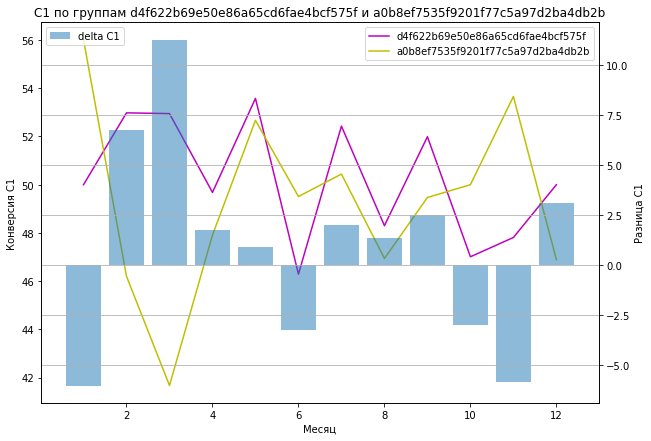

,operator_group_name,cnt_orders,cnt_is_paid,c1_operator_group_name
0,d4f622b69e50e86a65cd6fae4bcf575f,302,151,50.00
1,a0b8ef7535f9201f77c5a97d2ba4db2b,209,98,46.89


In [425]:
# визуализация динамики конверсии двух основных групп операторов
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 1, 1)
ax2 = ax1.twinx()

plt.title('C1 по группам d4f622b69e50e86a65cd6fae4bcf575f и a0b8ef7535f9201f77c5a97d2ba4db2b')
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Конверсия С1')
ax2.set_ylabel('Разница С1')
plt.grid()

lst_d4f622b69e50e86a65cd6fae4bcf575f = []
lst_a0b8ef7535f9201f77c5a97d2ba4db2b = []
months = [1,2,3,4,5,6,7,8,9,10,11,12]

for i in range(1,13):
    df_orders_month = df_orders.loc[df_orders['application_datetime'].dt.year == 2020].loc[df_orders['application_datetime'].dt.month == i]
    df_orders_month_d4f622b69e50e86a65cd6fae4bcf575f = df_orders_month.loc[df_orders_month['operator_group_name'] == 'd4f622b69e50e86a65cd6fae4bcf575f']
    df_orders_month_a0b8ef7535f9201f77c5a97d2ba4db2b = df_orders_month.loc[df_orders_month['operator_group_name'] == 'a0b8ef7535f9201f77c5a97d2ba4db2b']
    df_orders_month_groups = pd.concat([df_orders_month_d4f622b69e50e86a65cd6fae4bcf575f, df_orders_month_a0b8ef7535f9201f77c5a97d2ba4db2b])
    df_orders_month_groups = calculation_с1(df_orders_month_groups, 'operator_group_name')
    lst_d4f622b69e50e86a65cd6fae4bcf575f.append(df_orders_month_groups['c1_operator_group_name'][0])
    lst_a0b8ef7535f9201f77c5a97d2ba4db2b.append(df_orders_month_groups['c1_operator_group_name'][1])

ax1.plot(months, lst_d4f622b69e50e86a65cd6fae4bcf575f,
            c='m',
            label='d4f622b69e50e86a65cd6fae4bcf575f')
ax1.plot(months, lst_a0b8ef7535f9201f77c5a97d2ba4db2b,
         c='y',
         label='a0b8ef7535f9201f77c5a97d2ba4db2b')
ax1.legend()

delta = list()
for item1, item2 in zip(lst_d4f622b69e50e86a65cd6fae4bcf575f, lst_a0b8ef7535f9201f77c5a97d2ba4db2b):
    item = item1 - item2
    delta.append(item)

ax2.bar(months, delta,
       alpha = 0.5,
       label='delta C1')
ax2.legend(loc='upper left')
plt.show()
# Май месяц, который был наилучший с точки зрения конверсии, оказался успешным для обоих групп. На конверсию не повлияла
# работа какой-то определенной группы 1 линии. Стоит рассмотреть какие были изменения в других процессах связанные с С1, 
# например работа МВУ.
# По визуализации "C1 по группам d4f622b69e50e86a65cd6fae4bcf575f и a0b8ef7535f9201f77c5a97d2ba4db2b" стоит обратить внимание
# на месяцы, в которых существует существенная разница в С1 между группами операторов - это 1, 2, 3, 10, 12 месяц. В данные
# месяцы у групп отличается тренд С1, пока у одной группы конверсия растет, у второй группы падает или наоборот. 


In [489]:
# вычислим время между датой подачи заявки и первым успешным звонком
df_orders['order2call'] = df_orders['first_reach'] - df_orders['application_datetime']

def rank_order2call(time):
    if time < np.timedelta64(4, 'h'):
        return 1
    elif time < np.timedelta64(8, 'h'):
        return 2
    elif time < np.timedelta64(12, 'h'):
        return 3
    elif time < np.timedelta64(16, 'h'):
        return 4
    elif time < np.timedelta64(20, 'h'):
        return 5
    elif time < np.timedelta64(1, 'D'):
        return 6
    elif time < (np.timedelta64(1, 'D') + np.timedelta64(8, 'h')):
        return 7
    elif time < (np.timedelta64(1, 'D') + np.timedelta64(16, 'h')):
        return 8
    elif time < np.timedelta64(2, 'D'):
        return 9
    elif time < np.timedelta64(3, 'D'):
        return 10
    elif time < np.timedelta64(4, 'D'):
        return 11
    elif time < np.timedelta64(7, 'D'):
        return 12
    else:
        return 13
                               
df_orders['rank_order2call'] = df_orders['order2call'].apply(rank_order2call)
df_order2call = calculation_с1(df_orders, 'rank_order2call')
df_order2call
# Наблюдается явная корреляция между С1 и промежутком времени между подачей заявки и первым успешным звонком оператора.
# Самое лучшие время для первого звонка (успешного) с точки зрения С1 это промежуток между 4 и 12 часами после подачи
# заявки.
# Также видно, что самое неудачный промежуток это сразу после подачи заявки (до 4 часов) и по прошествию времени больше 7 дней

# и время между первым успешным звонком и проведенным ВУ
df_orders['call2trial'] = df_orders['trial_appointment_datetime'] - df_orders['first_reach']

def rank_call2trial(time):
    if time < np.timedelta64(0, 'm'):
        return 1
    elif time < np.timedelta64(4, 'h'):
        return 2
    elif time < np.timedelta64(8, 'h'):
        return 3
    elif time < np.timedelta64(12, 'h'):
        return 4
    elif time < np.timedelta64(16, 'h'):
        return 5
    elif time < np.timedelta64(20, 'h'):
        return 6
    elif time < np.timedelta64(24, 'h'):
        return 7
    elif time < np.timedelta64(28, 'h'):
        return 8
    elif time < np.timedelta64(1, 'W'):
        return 9
    else:
        return 10

df_orders['rank_call2trial'] = df_orders['call2trial'].apply(rank_call2trial)
df_call2trial = calculation_с1(df_orders, 'rank_call2trial')
df_call2trial
# Первый квантиль по промежутку времени между первым успешным звонком и проведенным ВУ составляет: -1 days +09:04:41.851726250
# т.е. каждый четвертый ВУ проводится раньше, чем первый успешный звонок оператора. Необходимо больше сведений по таким кейсам.
# Или существует другой способ записи на ВУ без оператора, например через ЛКУ, или это оплата уроков без проведения ВУ,
# и в таких случаях дата ВУ выставляется раньше первого успешного звонка.
# Лучшая конверсия наблюдается в промежутке между 24 и 28 часами, как был совершен первым успешный звонок и проведением ВУ.
# Однако такие данные сложно интерпретировать, визуально корреляция между С1 и промежутком времени между первым успешным звонком 
# и проведением ВУ не наблюдается.

# вычислим время между датой подачи заявки и ВУ
df_orders['order2trial'] = df_orders['trial_appointment_datetime'] - df_orders['application_datetime']

def rank_order2trial(time):
    if time < np.timedelta64(4, 'h'):
        return 1
    elif time < np.timedelta64(8, 'h'):
        return 2
    elif time < np.timedelta64(12, 'h'):
        return 3
    elif time < np.timedelta64(16, 'h'):
        return 4
    elif time < np.timedelta64(20, 'h'):
        return 5
    elif time < np.timedelta64(24, 'h'):
        return 6
    elif time < np.timedelta64(28, 'h'):
        return 7
    elif time < np.timedelta64(32, 'h'):
        return 8
    elif time < np.timedelta64(36, 'h'):
        return 9
    elif time < np.timedelta64(40, 'h'):
        return 10
    elif time < np.timedelta64(3, 'D'):
        return 11
    else:
        return 12
                               
df_orders['rank_order2trial'] = df_orders['order2trial'].apply(rank_order2trial)
df_order2trial = calculation_с1(df_orders, 'rank_order2trial')
df_order2trial.sort_values('rank_order2trial')
# Аналогично call2trial, лучшая конверсия между 24 и 28 часами.


,rank_order2trial,cnt_orders,cnt_is_paid,c1_rank_order2trial
11,1,719,353,49.10
9,2,757,362,47.82
7,3,782,400,51.15
6,4,836,422,50.48
5,5,867,440,50.75
0,6,932,455,48.82
4,7,870,478,54.94
3,8,902,436,48.34
1,9,916,456,49.78
2,10,916,461,50.33


In [ ]:
# Т.к. качество ВУ является важным фактором, определяющим конверсию С1, считаю нужным отдельно проанализировать данные 
# в этом направлении. Для этого необходимы получить ID МВУ, группу и тип МВУ.